In [1]:
from IPython import get_ipython

In [9]:
if get_ipython():
    get_ipython().run_line_magic("load_ext", "autoreload")
    get_ipython().run_line_magic("autoreload", "2")
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import seaborn as sns
import sys
import scanpy as sc
import latenta as la
import jax
import jax.numpy as jnp
import optax
import tqdm.auto as tqdm
import scipy
import random
import re
import dill as pickle
import sklearn.decomposition
import os
import eyck
from general_functions.model_generation_functions import *
from general_functions.model_visualization_functions import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# part1

In [10]:
def map_nested_fn(fn):
    """Recursively apply `fn` to key-value pairs of a nested dict."""
    def map_fn(nested_dict):
        return {k: (map_fn(v) if isinstance(v, dict) else fn(k, v)) for k, v in nested_dict.items()}
    return map_fn

In [11]:
@map_nested_fn
def label_fn(k, v):
    # print(k)
    if ("kernel" in k) or ("bias" in k):
        return "a"
    else:
        return "b"

In [5]:
optimizer = optax.multi_transform({"b": optax.adam(5e-3), "a": optax.adam(1e-4)}, label_fn)

In [ ]:
# random models
with open("random_model/scores.pkl", "rb") as f:
    scores1 = pickle.load(f)
with open("random_model/dictionary.pkl", "rb") as f:
    model_dict1 = pickle.load(f)

# partial crossover
with open("partial_crossover/scores.pkl", "rb") as f:
    scores2 = pickle.load(f)
with open("partial_crossover/dictionary.pkl", "rb") as f:
    model_dict2 = pickle.load(f)

# full crossover
with open("full_crossover/scores.pkl", "rb") as f:
    scores3 = pickle.load(f)
with open("full_crossover/dictionary.pkl", "rb") as f:
    model_dict3 = pickle.load(f)


In [ ]:
with open("elitism/scores.pkl", "rb") as f:
    scores4 = pickle.load(f)
with open("elitism/dictionary.pkl", "rb") as f:
    model_dict4 = pickle.load(f)

with open("pruning/scores.pkl", "rb") as f:
    scores5 = pickle.load(f)
with open("pruning/dictionary.pkl", "rb") as f:
    model_dict5 = pickle.load(f)

In [ ]:
with open("biased_models/scores.pkl", "rb") as f:
    scores6 = pickle.load(f)
with open("biased_models/model_dict.pkl", "rb") as f:
    model_dict6 = pickle.load(f)

In [7]:
def group_model(row):
    if row["architecture"] == "unbiased_initialization_biased_model":
        return "unbiased_initialization"
    elif row["architecture"] == "biased_initialization_biased_model":
        return "biased_initialization"
    else:
        return f"{row['number_of_effects']}"

scores6["initialisation"] = scores6.apply(group_model, axis=1)

In [ ]:
scores_list = [scores1,scores2,scores3,scores4]
model_dict_list = [model_dict1,model_dict2,model_dict3,model_dict4]
scores_names = ["no_crossover", "partial_crossover","full_crossover", "elitism"]

scores = pd.DataFrame()
for i, score in enumerate(scores_list):
    for initialization in ["unbiased_initialization", "semi_biased_initialization"]:
        new_scores = score[score["initialisation"] == initialization]
        new_scores = new_scores.reset_index(drop=True)
        best_model_elbo = new_scores.iloc[new_scores["elbo"].idxmax()]["elbo"]

        new_row = {"method": scores_names[i],"initialization":initialization, "elbo": best_model_elbo }
        scores = pd.concat([scores, pd.DataFrame([new_row])], ignore_index=True)

In [ ]:
best_model_elbo = scores5.iloc[scores5["elbo"].idxmax()]["elbo"]
new_row = {"method": "pruning","initialization":"unbiased_initialization", "elbo": best_model_elbo}
scores = pd.concat([scores, pd.DataFrame([new_row])], ignore_index=True)

In [ ]:
unbiased_scores = scores6[scores6["initialisation"] == "unbiased_initialization"]
biased_scores = scores6[scores6["initialisation"] == "biased_initialization"]
biased_scores = biased_scores.reset_index(drop=True)

u_best_model_elbo = unbiased_scores.iloc[unbiased_scores["elbo"].idxmax()]["elbo"]
b_best_model_elbo = biased_scores.iloc[biased_scores["elbo"].idxmax()]["elbo"]

new_row = {"method": "biased_models","initialization":"unbiased_initialization", "elbo": u_best_model_elbo}
scores = pd.concat([scores, pd.DataFrame([new_row])], ignore_index=True)
new_row = {"method": "biased_models","initialization":"biased_initialization", "elbo": b_best_model_elbo }
scores = pd.concat([scores, pd.DataFrame([new_row])], ignore_index=True)

In [11]:
scores

,method,initialization,elbo
0,no_crossover,unbiased_initialization,-70173512.0
1,no_crossover,semi_biased_initialization,-70173856.0
2,partial_crossover,unbiased_initialization,-70151344.0
3,partial_crossover,semi_biased_initialization,-70111944.0
4,full_crossover,unbiased_initialization,-70165624.0
5,full_crossover,semi_biased_initialization,-70169080.0
6,elitism,unbiased_initialization,-70204752.0
7,elitism,semi_biased_initialization,-70154312.0
8,pruning,unbiased_initialization,-70123888.0
9,biased_models,unbiased_initialization,-70378472.0


In [12]:
scores["initialization"] = scores["initialization"].replace("semi_biased_initialization", "PCA_initialized")

In [13]:
scores["method"] = scores["method"].replace("biased_models", "biased_architecture")

In [14]:
# Create a combined label for method and initialization
scores["combined_label"] = scores[["method", "initialization"]].apply(" - ".join, axis=1)

# Generate a base palette for methods
method_palette = sns.color_palette("husl", len(scores["method"].unique()))
method_palette = dict(zip(scores["method"].unique(), method_palette))

# Create a new palette with lighter/darker variations for initialization types
combined_palette = {}
for label in scores["combined_label"].unique():
    method, initialization = label.split(" - ")
    base_color = method_palette[method]
    if "unbiased_initialization" in initialization:
        combined_palette[label] = sns.light_palette(base_color, n_colors=3)[1]  # Slightly lighter
    elif "PCA_initialized" in initialization:
        combined_palette[label] = sns.light_palette(base_color, n_colors=3)[2]  # Slightly darker
    elif "biased_initialization" in initialization:
        combined_palette[label] = sns.light_palette(base_color, n_colors=4)[3]  # Slightly darker

In [ ]:
def boxplot_per_generation(scores, divide_by_columns=["method", "initialization"], y="elbo"):
    """
    Plot ELBO (or other metrics) per generation with combined source and initialization hues.

    Parameters:
    - scores: DataFrame containing the scores and generation information.
    - divide_by_columns: Columns to combine for hue labels (default: ["method", "initialization"]).
    - y: Column name for the metric to plot on the y-axis (default: "elbo").
    """
    # Create a combined label for method and initialization
    scores["combined_label"] = scores[divide_by_columns].apply(" - ".join, axis=1)

    # Generate a base palette for methods
    method_palette = sns.color_palette("husl", len(scores["method"].unique()))
    method_palette = dict(zip(scores["method"].unique(), method_palette))

    # Create a new palette with lighter/darker variations for initialization types
    combined_palette = {}
    for label in scores["combined_label"].unique():
        method, initialization = label.split(" - ")
        base_color = method_palette[method]
        if "unbiased_initialization" in initialization:
            combined_palette[label] = sns.light_palette(base_color, n_colors=3)[1]  # Slightly lighter
        elif "PCA_initialized" in initialization:
            combined_palette[label] = sns.light_palette(base_color, n_colors=3)[2]  # Slightly darker
        elif "biased_initialization" in initialization:
            combined_palette[label] = sns.light_palette(base_color, n_colors=4)[3]  # Slightly darker

    # Set figure size
    plt.figure(figsize=(14, 8))

    # Add a stripplot for additional clarity
    sns.stripplot(
        x="method",
        y=y,
        hue="combined_label",  # Same hue as boxplot
        data=scores,
        dodge=True,
        alpha=1,
        marker="o",
        palette=combined_palette,
        jitter=False,
        linewidth=0.2,
        size=10
    )

    # Customize the legend
    plt.legend(
        title="Method - Initialization Type",
        bbox_to_anchor=(1.05, 1), loc="upper left", fontsize=10
    )

    # Add titles and labels
    plt.title(f"Best model {y} per method", fontsize=16)
    plt.xlabel("Method", fontsize=14)
    plt.ylabel(y, fontsize=14)
    plt.xticks(rotation=45)  # Rotate x-axis labels if needed
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

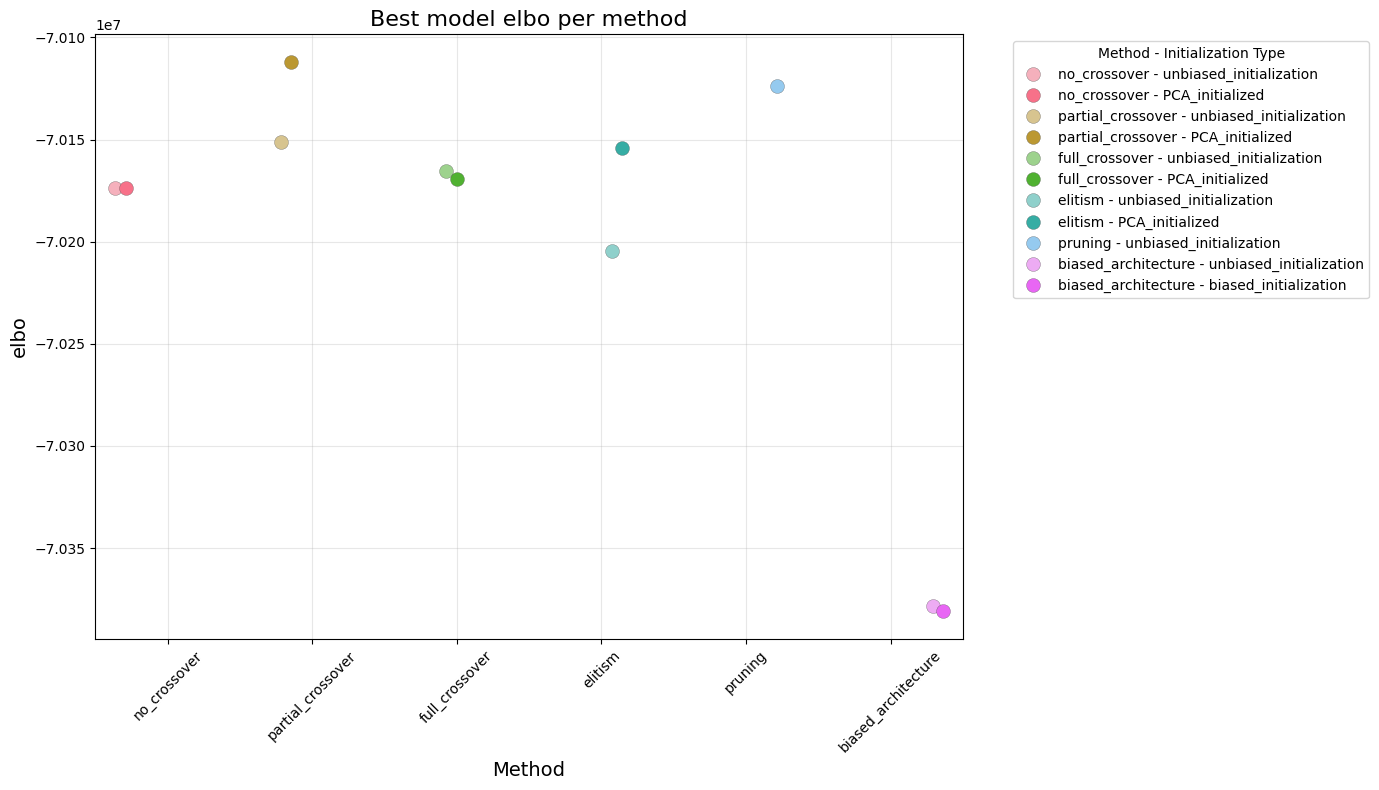

In [27]:
boxplot_per_generation(scores, divide_by_columns=["method", "initialization"], y="elbo")

# part2

In [10]:
scores = [globals()[f'scores{i+1}'] for i in range(6)]
scores_names = ["no_crossover", "partial_crossover","full_crossover", "elitism", "pruning", "biased_models"]
for i, score in enumerate(scores):
    score["method"] = scores_names[i]

In [11]:
scores6["generation"] = 0

In [12]:
scores5["initialisation"] = "unbiased_initialization"

In [13]:
model_dict5 = {"unbiased_initialization": model_dict5}

In [14]:
temp_dict1 = {}
temp_dict2 = {}
for key, value in model_dict6.items():
    if key.startswith("unbiased_initialization"):
        temp_dict1[key] = value
    else:
        temp_dict2[key] = value

model_dict6 = {"unbiased_initialization":{0:temp_dict1},
               "biased_initialization":{0:temp_dict2}}


In [15]:
model_dicts = [globals()[f'model_dict{i+1}'] for i in range(6)]

In [ ]:
## select best models
best_model_scores = pd.DataFrame()
best_model_dict = {}

for score, model_dict in zip(scores, model_dicts):
    inner_dict = {}
    for initialization_type in score["initialisation"].unique():
        subset_score = score[score["initialisation"] == initialization_type]

        best_idx = subset_score["elbo"].idxmax()

        # Ensure `best_model_score` is a DataFrame
        best_model_score = subset_score.loc[[best_idx]]  # Double brackets for DataFrame
        
        # Concatenate without issues
        best_model_scores = pd.concat([best_model_scores, best_model_score], ignore_index=True)
        
        # Extract details from the DataFrame row
        best_model_name = best_model_score.iloc[0]["model_name"]
        generation = best_model_score.iloc[0]["generation"]
        method = best_model_score.iloc[0]["method"]

        

        # Access the best model
        best_model = model_dict[initialization_type][generation][best_model_name][0]
        inner_inner_dict = {}
        inner_inner_dict[best_model_name] = best_model
        inner_dict[initialization_type] = inner_inner_dict
    
    best_model_dict[method] = inner_dict


In [ ]:
safe_pickle(best_model_dict, "best_model_dict.pkl", "model_comparison")

Successfully saved to model_comparison/worst_model_dict.pkl


In [ ]:
## select worst models
best_model_scores = pd.DataFrame()
best_model_dict = {}

for score, model_dict in zip(scores, model_dicts):
    inner_dict = {}
    for initialization_type in score["initialisation"].unique():
        subset_score = score[score["initialisation"] == initialization_type]
        if subset_score["method"].unique()[0] == "biased_models":
            best_idx = subset_score["elbo"].idxmax()
        else:
            best_idx = subset_score["elbo"].idxmin()
        # Ensure `best_model_score` is a DataFrame
        best_model_score = subset_score.loc[[best_idx]]  # Double brackets for DataFrame
        
        # Concatenate without issues
        best_model_scores = pd.concat([best_model_scores, best_model_score], ignore_index=True)
        
        # Extract details from the DataFrame row
        best_model_name = best_model_score.iloc[0]["model_name"]
        generation = best_model_score.iloc[0]["generation"]
        method = best_model_score.iloc[0]["method"]

        

        # Access the best model
        best_model = model_dict[initialization_type][generation][best_model_name][0]
        inner_inner_dict = {}
        inner_inner_dict[best_model_name] = best_model
        inner_dict[initialization_type] = inner_inner_dict
    
    best_model_dict[method] = inner_dict


In [26]:
safe_pickle(best_model_dict, "worst_model_dict.pkl", "model_comparison")

Successfully saved to model_comparison/worst_model_dict.pkl


In [3]:
with open('model_comparison/best_model_dict.pkl', "rb") as f:
    best_model_dict = pickle.load(f)

In [3]:
with open('model_comparison/worst_model_dict.pkl', "rb") as f:
    worst_model_dict = pickle.load(f)

In [ ]:
adata_dict = {}
for method, initialization_type in best_model_dict.items():
    inner_dict = {}

    for initialization_type, model_dict in initialization_type.items():
        for model_name, model in model_dict.items():
            adata = data_adata_converter(model, size=1000, complete=True)
            inner_inner_dict = {}
            inner_inner_dict[model_name] = adata
            inner_dict[initialization_type] = inner_inner_dict
            adata_dict[method] = {initialization_type: {model_name: adata}}
        
    adata_dict[method] = inner_dict

In [ ]:
safe_pickle(adata_dict, "best_adata_dict.pkl", "model_comparison")

Successfully saved to model_comparison/adata_dict.pkl


In [ ]:
adata_dict = {}
for method, initialization_type in worst_model_dict.items():
    inner_dict = {}

    for initialization_type, model_dict in initialization_type.items():
        for model_name, model in model_dict.items():
            adata = data_adata_converter(model, size=1000, complete=True)
            inner_inner_dict = {}
            inner_inner_dict[model_name] = adata
            inner_dict[initialization_type] = inner_inner_dict
            adata_dict[method] = {initialization_type: {model_name: adata}}
        
    adata_dict[method] = inner_dict

In [ ]:
safe_pickle(adata_dict, "worst_adata_dict.pkl", "model_comparison")

Successfully saved to model_comparison/adata_dict_worst.pkl


In [ ]:
with open('model_comparison/best_adata_dict.pkl', "rb") as f:
    adata_dict = pickle.load(f)

In [50]:
adata_dict.keys()

dict_keys(['no_crossover', 'partial_crossover', 'full_crossover', 'elitism', 'pruning', 'biased_models'])

In [51]:
for key, value in adata_dict.items():
    try:
        value["PCA_initialized"] = value.pop("semi_biased_initialization")
    except KeyError:
        pass

adata_dict['biased_architecture'] = adata_dict.pop('biased_models')

# part3

In [52]:
adata_list = []
titles = []
for method, initialization_type in adata_dict.items():
    for initialization_type, model_dict in initialization_type.items():
        for model_name, adata in model_dict.items():
            adata_list.append(adata)
            #titles.append(f'{method}')
            titles.append(f'{method}-{"_".join(initialization_type.split("_"))}')


In [53]:
titles

['no_crossover-unbiased_initialization',
 'no_crossover-PCA_initialized',
 'partial_crossover-unbiased_initialization',
 'partial_crossover-PCA_initialized',
 'full_crossover-unbiased_initialization',
 'full_crossover-PCA_initialized',
 'elitism-unbiased_initialization',
 'elitism-PCA_initialized',
 'pruning-unbiased_initialization',
 'biased_architecture-unbiased_initialization',
 'biased_architecture-biased_initialization']

In [54]:
titles[-2] = 'biased_architecture-.'
titles[-1] = 'biased_architecture-+initialization'

In [55]:
keys = list(combined_palette.keys())
for i, key in enumerate(keys):
    combined_palette[titles[i]] = combined_palette.pop(key)

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def circular_correlation(theta, phi):
    """
    Circular correlation from "A Correlation Coefficient for Circular Data", Fisher and Lee, Biometrika, 1983.
    """
    theta = np.asarray(theta) * 2 * np.pi  # Convert to numpy array and scale
    phi = np.asarray(phi) * 2 * np.pi  # Convert to numpy array and scale
    x = (np.sin(np.tril(theta - theta[:, None])) * np.sin(np.tril(phi - phi[:, None]))).sum()
    b = (np.sin(np.tril(theta - theta[:, None])) ** 2).sum()
    c = (np.sin(np.tril(phi - phi[:, None])) ** 2).sum()
    d = np.sqrt(b) * np.sqrt(c)
    return x / d

In [64]:
def add_side_accolade(
    ax, start, end, position, text, side="left", color="blue", lw=5, fontsize=5, offset=0.5, 
    combined_palette=None
):
    """
    Add an accolade with text annotation to the side (left or bottom) of the heatmap,
    splitting the text into two parts based on "-" and displaying them on two separate lines.

    :param ax: Matplotlib axis
    :param start: Start position of the accolade
    :param end: End position of the accolade
    :param position: Position along the axis (x or y based on side)
    :param text: Text to display near the accolade
    :param side: "left" for vertical, "bottom" for horizontal accolade
    :param color: Color of the accolade line
    :param lw: Line width of the accolade
    :param fontsize: Font size of the text
    :param offset: Offset for the accolade relative to the heatmap
    :param combined_palette: Dictionary for dynamic coloring of text based on `combined_label`
    """

    # Split the text into two parts based on "-"
    if text.endswith("."):
        text_parts = text[:-2]
    
    elif text.startswith("elitism"):
        text_parts = text
    else:
        text_parts = "\n".join(text.split("-"))

    # Determine the color for the text based on the combined_label if available
    text_color = combined_palette.get(text, "black") if combined_palette else color

    if side == "left":
        mid_y = (start + end) / 2

        # Draw the accolade (line) with the same color as the text
        ax.plot([0, 0], [start, end], color=text_color, lw=lw)

        # Add the first part of the text (above the accolade)
        ax.text(
            position - offset - 3, mid_y + 0.3, text_parts, color=text_color,
            ha="right", va="center", fontsize=fontsize, clip_on=False,
            bbox=dict(facecolor="white", edgecolor="black", boxstyle="round,pad=0.5")
        )

    elif side == "bottom":
        mid_x = (start + end) / 2

        # Draw the accolade (line) with the same color as the text
        ax.plot([start, end], [position + offset, position + offset], color=text_color, lw=lw)

        # Add the first part of the text (above the accolade)
        ax.text(
            mid_x, position + offset + 3, text_parts, color=text_color,
            ha="center", va="top", fontsize=fontsize, clip_on=False,
            bbox=dict(facecolor="white", edgecolor="black", boxstyle="round,pad=0.5"), rotation=90
        )


def all_vs_all_correlation_with_highlight(
    adata_list, 
    titles=None, 
    method="pearson", 
    model_text="All-vs-All Correlation (With Similarity Highlighting)", 
    similarity_threshold=0.7,
    match_percentage=0.8,
    check_circ_correlation=False,
    combined_palette=None
):
    """
    Generate an all-vs-all correlation matrix and highlight pairs of datasets that meet a similarity criterion.
    """
    if not combined_palette:
        # Generate a base palette for methods
        method_palette = sns.color_palette("husl", len(titles))
        method_palette = dict(zip(list(set([label.split("-")[0] for label in titles])), method_palette))
        
        # Create a new palette with lighter/darker variations for initialization types
        combined_palette = {}
        for label in list(set(titles)):
            method_name, initialization = label.split("-")
            base_color = method_palette[method_name]
            if "unbiased_initialization" in initialization:
                combined_palette[label] = sns.light_palette(base_color, n_colors=3)[1]  # Slightly lighter
            elif "PCA_initialized" in initialization:
                combined_palette[label] = sns.light_palette(base_color, n_colors=3)[2]  # Slightly darker
            elif "+initialization" in initialization:
                combined_palette[label] = sns.light_palette(base_color, n_colors=4)[3]  # Slightly darker
            
    # Flatten all columns from all AnnData objects into one list
    all_columns = []
    column_titles = []  # For labeling rows/columns in the heatmap
    dataset_boundaries = []
    dataset_sizes = []
    current_idx = 0

    for idx, adata in enumerate(adata_list):
        all_columns.append(adata.obs)
        prefix = titles[idx] if titles else f"Dataset {idx}"
        column_titles.extend([f"{col.split('.')[0]}" for col in adata.obs.columns])
        dataset_sizes.append(len(adata.obs.columns))
        current_idx += len(adata.obs.columns)
        dataset_boundaries.append(current_idx)  # Track boundaries

    # Concatenate all obs DataFrames into one
    combined_df = pd.concat(all_columns, axis=1)

    # Compute the correlation matrix
    correlation_matrix = abs(combined_df.corr(method=method))
    circular_count = 0
    # Handle circular correlations for columns with "CircularSpline" in the name
    for i in range(correlation_matrix.shape[0]):
        for j in range(i, correlation_matrix.shape[1]):  # Only need to fill upper triangle

            if "CircularSpline" in column_titles[i] and "CircularSpline" in column_titles[j] and check_circ_correlation:
                circular_count += 1
                # Apply circular correlation instead of linear correlation
                correlation_matrix.iloc[i, j] = circular_correlation(combined_df.iloc[:, i], combined_df.iloc[:, j])
                correlation_matrix.iloc[j, i] = correlation_matrix.iloc[i, j]
    print(circular_count)

    # Determine dataset similarity
    num_datasets = len(adata_list)
    similar_datasets = np.zeros((num_datasets, num_datasets), dtype=bool)
    for i, size_i in enumerate(dataset_sizes):
        for j, size_j in enumerate(dataset_sizes):
            if i >= j:
                continue  # Avoid redundant calculations (matrix is symmetric)
            
            start_i = sum(dataset_sizes[:i])
            end_i = start_i + size_i
            start_j = sum(dataset_sizes[:j])
            end_j = start_j + size_j
            
            subset_corr = correlation_matrix.iloc[start_i:end_i, start_j:end_j]
            high_corr_count = (subset_corr.abs() >= similarity_threshold).sum().sum()
            min_size = min(size_i, size_j)
            threshold = int(np.ceil(min_size * (match_percentage / 1)))  # Calculate required matches
            similar_datasets[i, j] = high_corr_count >= threshold
            similar_datasets[j, i] = similar_datasets[i, j]

    # Plot the heatmap
    plt.figure(figsize=(20, 20))
    ax = sns.heatmap(
        correlation_matrix,
        xticklabels=column_titles,
        yticklabels=column_titles,
        cmap="Reds",  # Grey-to-red colormap
        annot=False,  # Disable numerical annotations
        cbar_kws={'label': f'{method.capitalize()} Correlation Coefficient'},
        linewidths=0.5,  # Add small lines between cells
        vmin=0.7, vmax=1,  # Set range from 0 to 1 for correlations
    )
    plt.title(model_text, fontsize=14, fontweight="bold")
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)

    # Add dataset boundaries
    for boundary in dataset_boundaries:
        plt.axhline(boundary, color="black", linewidth=1.5)
        plt.axvline(boundary, color="black", linewidth=1.5)

    # Highlight similar dataset pairs
    for i in range(num_datasets):
        for j in range(i + 1, num_datasets):
            if similar_datasets[i, j]:
                start_i = sum(dataset_sizes[:i])
                end_i = start_i + dataset_sizes[i]
                start_j = sum(dataset_sizes[:j])
                end_j = start_j + dataset_sizes[j]
                ax.add_patch(plt.Rectangle((start_j, start_i), dataset_sizes[j], dataset_sizes[i],
                                            fill=False, edgecolor="green", lw=5))


    # Example call to add accolades for each method/initialization
    for idx, method_name in enumerate(titles):
        start = sum(dataset_sizes[:idx])
        end = start + dataset_sizes[idx]
        
        add_side_accolade(
            ax, start, end, position=-1, text=method_name, side="left", offset=0, combined_palette=combined_palette, fontsize=12 
        )
        add_side_accolade(
            ax, start, end, position=correlation_matrix.shape[0], text=method_name, side="bottom", offset=0, combined_palette=combined_palette, fontsize=12
        )

    plt.tight_layout()
    plt.show()


36


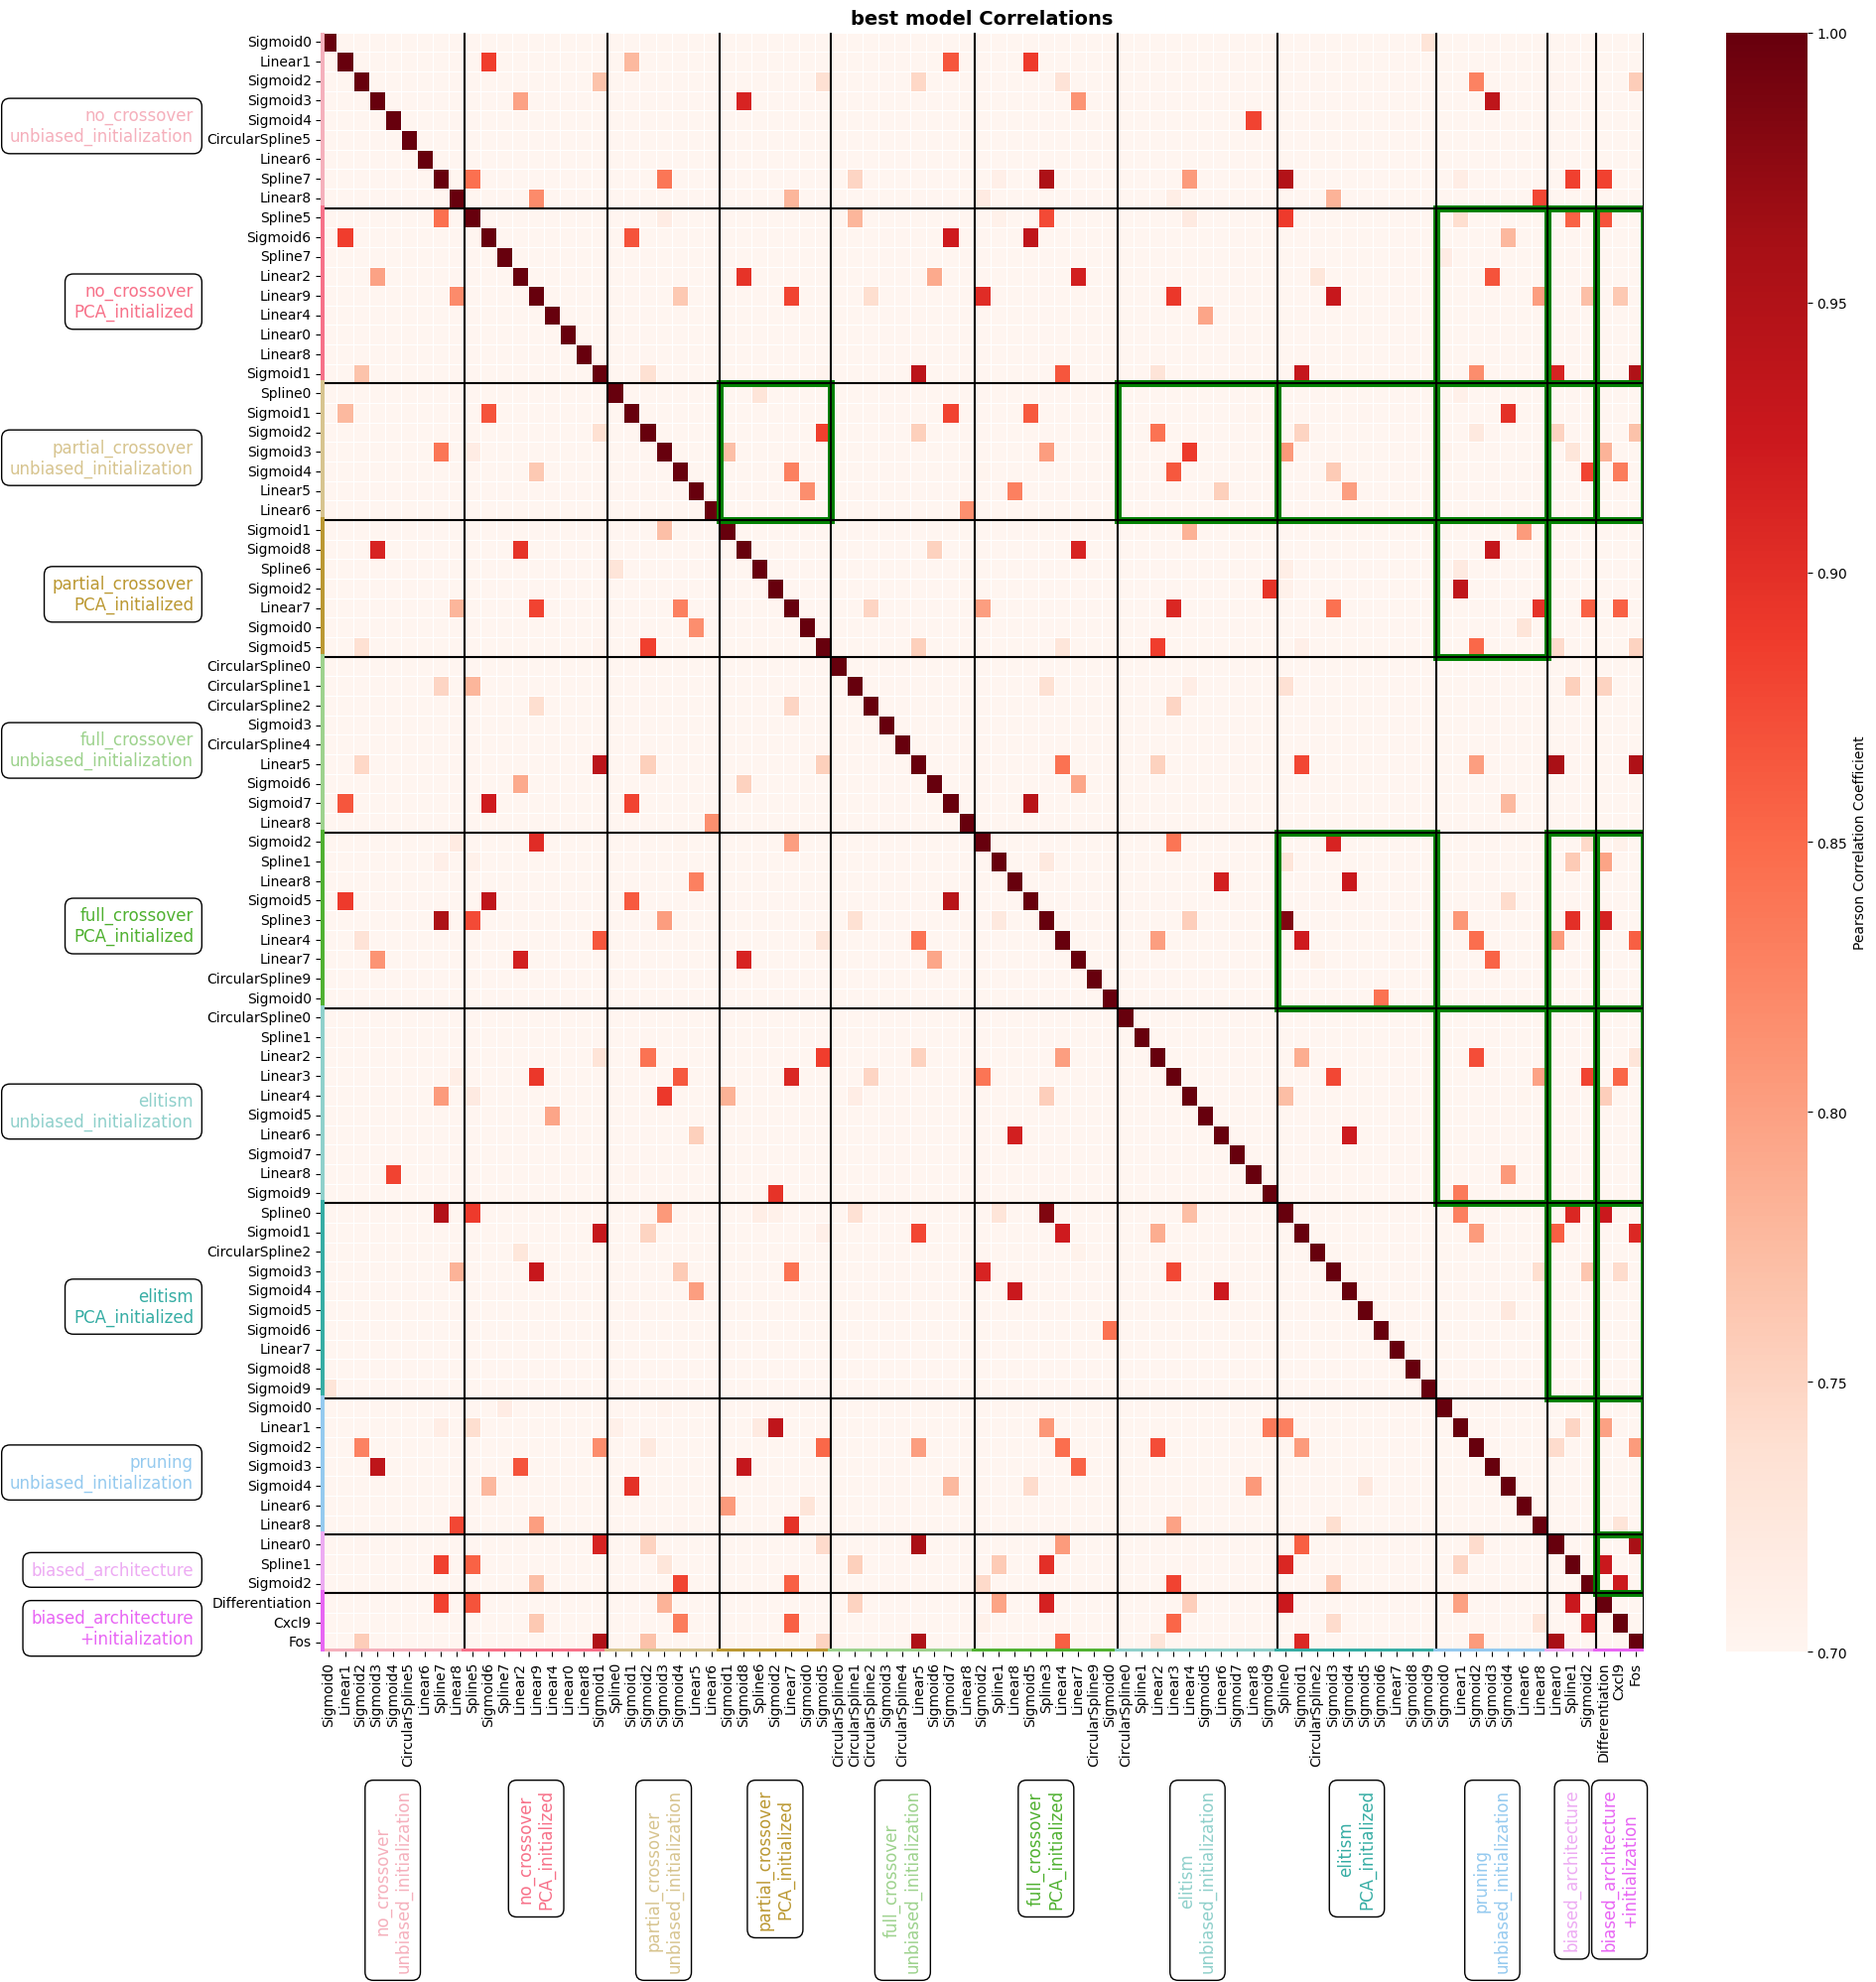

In [48]:
all_vs_all_correlation_with_highlight(
    adata_list, 
    titles=titles, 
    method="pearson", 
    model_text="best model Correlations", 
    similarity_threshold=0.7,
    match_percentage=0.7,
    check_circ_correlation=True,
    combined_palette=combined_palette,
)

In [ ]:
with open('model_comparison/worst_adata_dict.pkl', "rb") as f:
    adata_dict = pickle.load(f)

In [ ]:
adata_dict.keys()

dict_keys(['no_crossover', 'partial_crossover', 'full_crossover', 'elitism', 'pruning', 'biased_models'])

In [ ]:
for key, value in adata_dict.items():
    try:
        value["PCA_initialized"] = value.pop("semi_biased_initialization")
    except KeyError:
        pass

adata_dict['biased_architecture'] = adata_dict.pop('biased_models')

In [ ]:
adata_list = []
titles = []
for method, initialization_type in adata_dict.items():
    for initialization_type, model_dict in initialization_type.items():
        for model_name, adata in model_dict.items():
            adata_list.append(adata)
            #titles.append(f'{method}')
            titles.append(f'{method}-{"_".join(initialization_type.split("_"))}')


In [ ]:
titles

['no_crossover-unbiased_initialization',
 'no_crossover-PCA_initialized',
 'partial_crossover-unbiased_initialization',
 'partial_crossover-PCA_initialized',
 'full_crossover-unbiased_initialization',
 'full_crossover-PCA_initialized',
 'elitism-unbiased_initialization',
 'elitism-PCA_initialized',
 'pruning-unbiased_initialization',
 'biased_architecture-unbiased_initialization',
 'biased_architecture-biased_initialization']

In [ ]:
titles[-2] = 'biased_architecture-.'
titles[-1] = 'biased_architecture-+initialization'

In [ ]:
keys = list(combined_palette.keys())
for i, key in enumerate(keys):
    combined_palette[titles[i]] = combined_palette.pop(key)

10


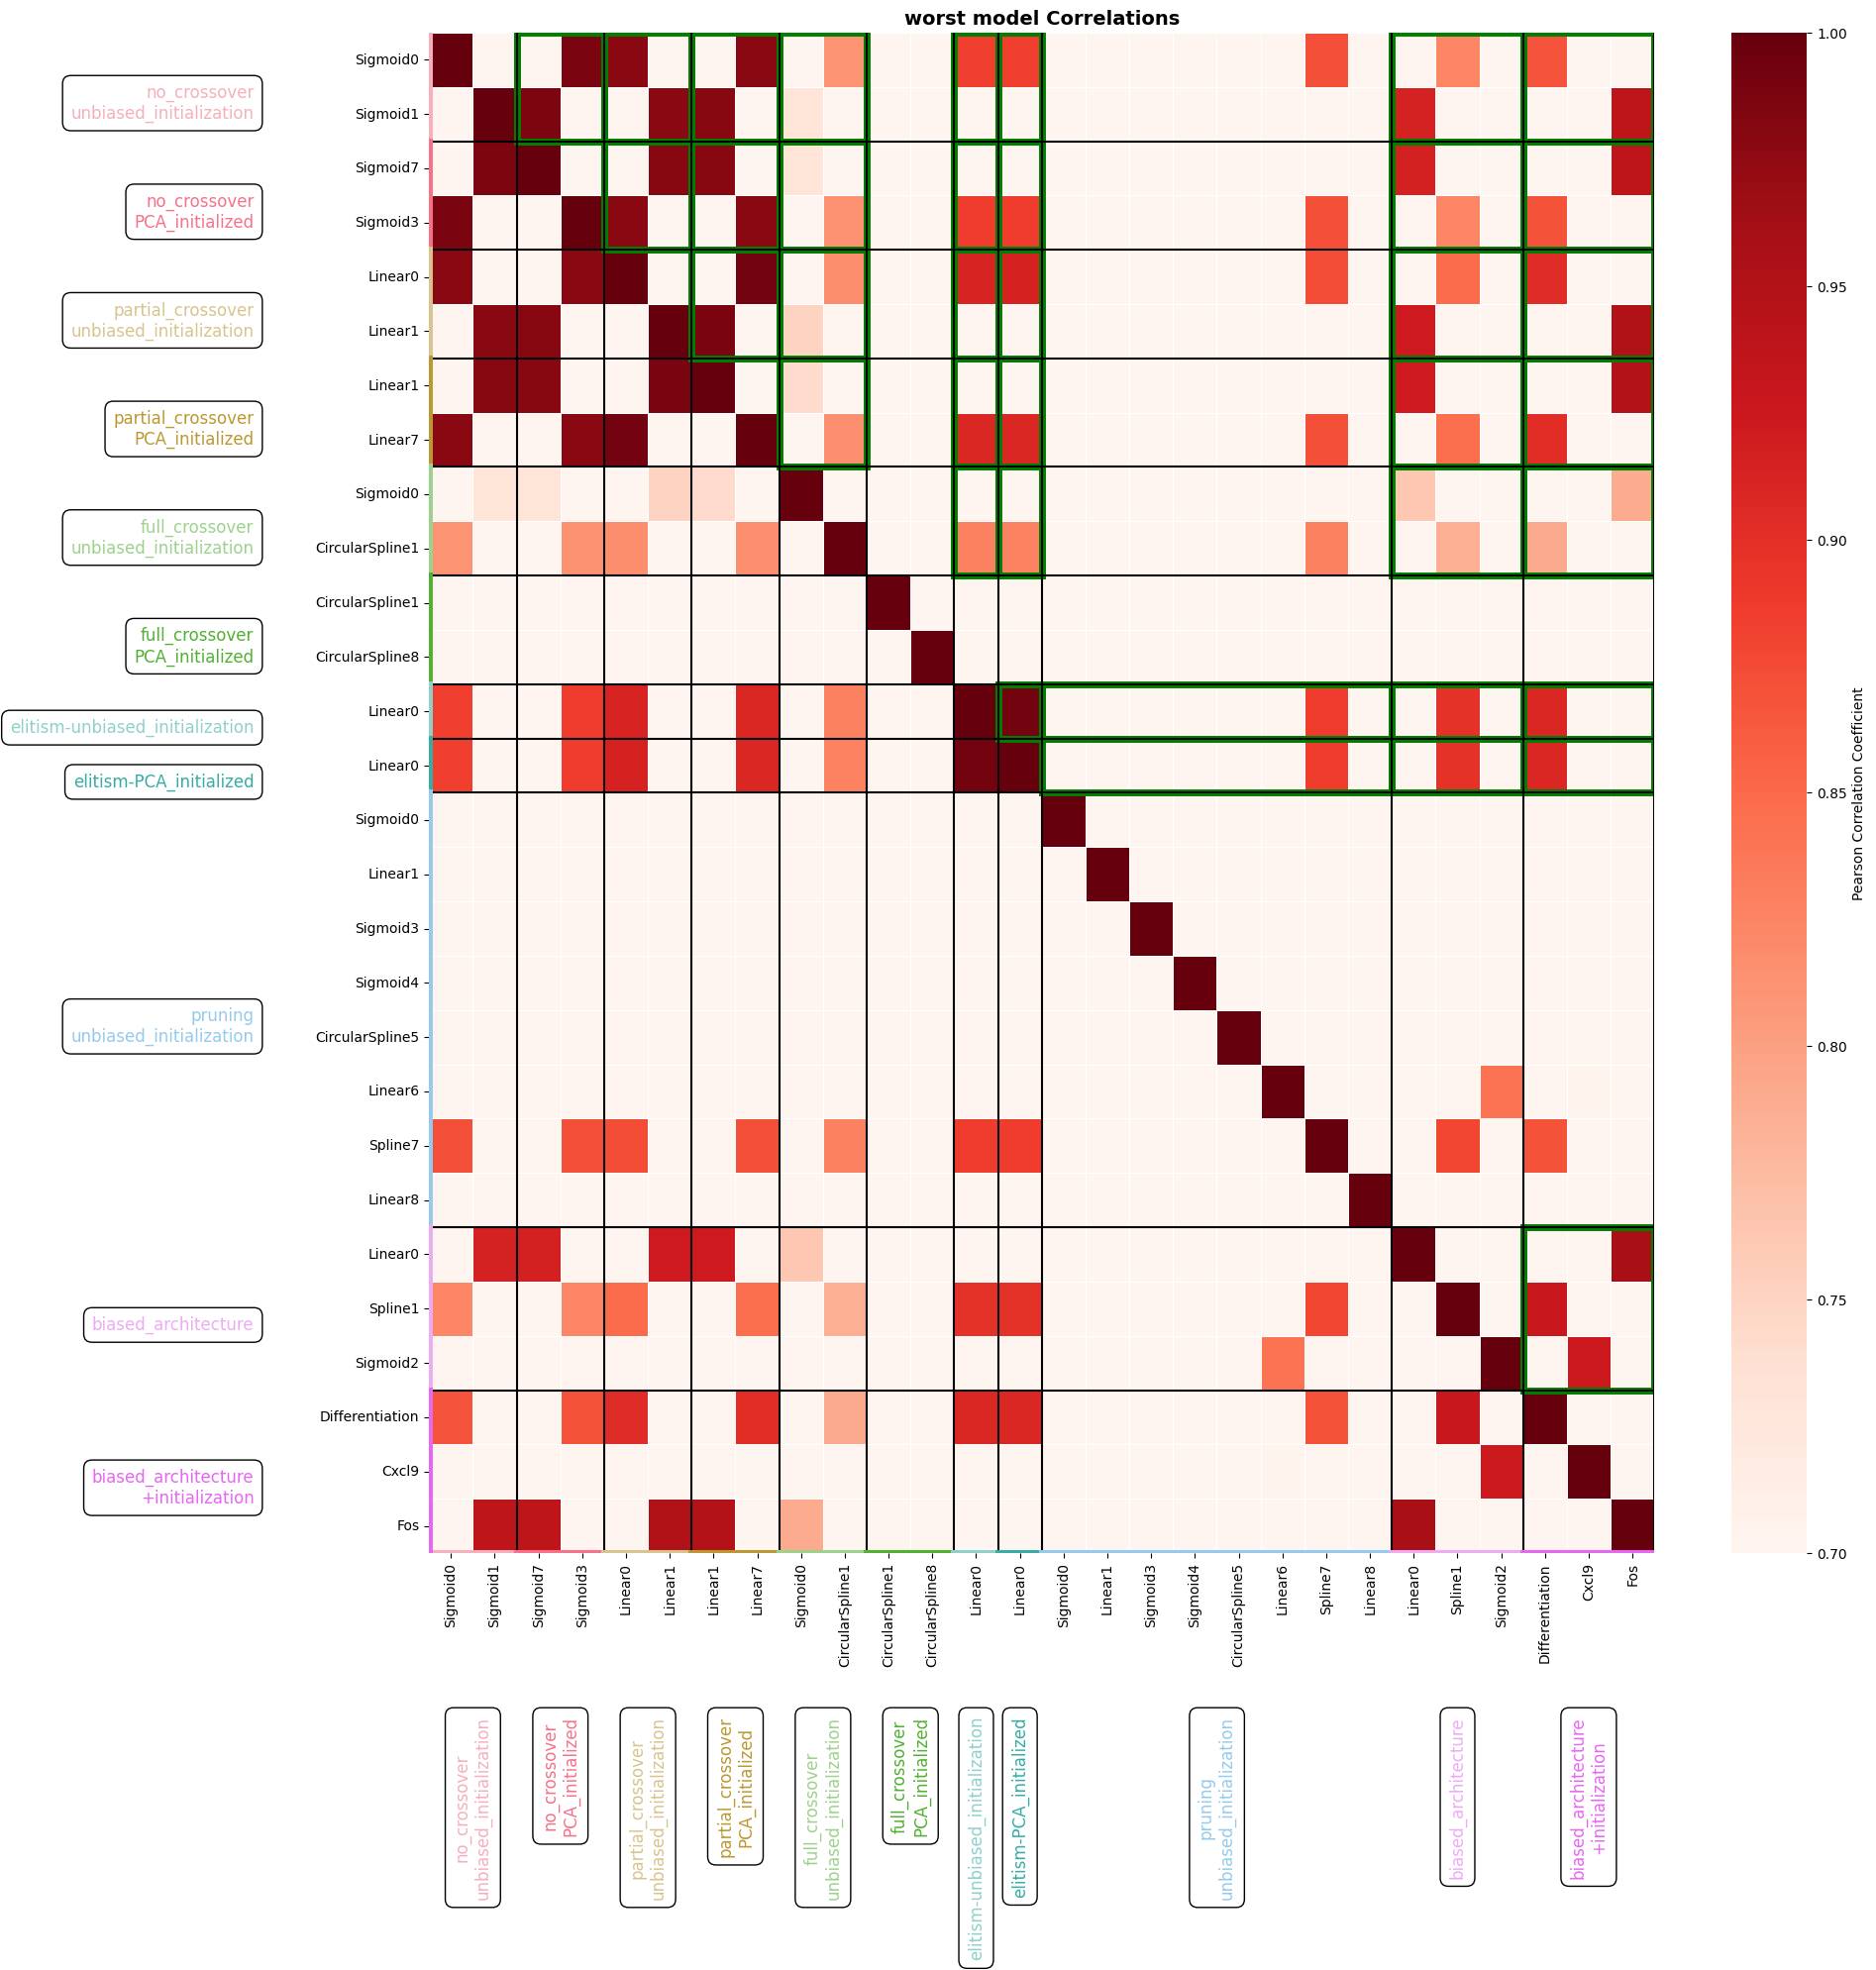

In [66]:
all_vs_all_correlation_with_highlight(
    adata_list, 
    titles=titles, 
    method="pearson", 
    model_text="worst model Correlations", 
    similarity_threshold=0.7,
    match_percentage=0.7,
    check_circ_correlation=True,
    combined_palette=combined_palette,
)